<a href="https://colab.research.google.com/github/ychoi-kr/aiforprofit/blob/main/notebooks/ac_02_nmist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 추가 사례 2: 이미지 판별하기(다중 분류)

### 공통 전처리

In [1]:
# 공통 처리

# 불필요한 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 글꼴 설정
import platform

if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='Apple Gothic')

# 데이터프레임 출력용 함수
from IPython.display import display

# 숫자 출력 조정
# 넘파이 부동소수점 출력 자리수 설정
np.set_printoptions(suppress=True, precision=4)

# 판다스 부동소수점 출력 자리수 설정
pd.options.display.float_format = '{:.4f}'.format

# 데이터프레임 모든 필드 출력
pd.set_option("display.max_columns",None)

# 그래프 글꼴 크기 설정
plt.rcParams["font.size"] = 14

# 난수 시드
random_seed = 123

In [2]:
# 혼동행렬 출력용 함수

def make_cm(matrix, columns):
    # matrix : 넘파이 배열
    # columns : 필드명 리스트
    n = len(columns)
    
    # '정답 데이터'를 n번 반복해 연접한 리스트
    act = ['정답데이터'] * n
    pred = ['예측결과'] * n
    
    # 데이터프레임 생성
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    return cm

### A2.4 데이터 읽어 들이기부터 데이터 확인까지

#### 데이터 읽어 들이기

In [3]:
# 데이터 읽어 들이기

# 숫자 손글씨 데이터
# 시간이 상당히 걸리므로 주의할 것
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)

In [4]:
# 이미지 데이터
image = mnist.data.values

# 정답 데이터
label = mnist.target

# 문자열을 숫자값으로 변환
y = label.astype(np.int)

In [5]:
# 데이터 상세 정보 확인

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

#### 데이터 확인

In [6]:
# 배열의 크기 확인
print("이미지 데이터 건수:", image.shape)
print("정답 데이터 건수:", y.shape)

이미지 데이터 건수: (70000, 784)
정답 데이터 건수: (70000,)


In [7]:
# 레이블과 숫자값 레이블 확인
print(label[:10])
print(y[:10])

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: int64


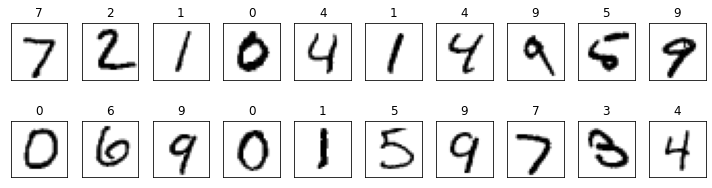

In [8]:
# 검증 데이터의 처음 20건 이미지를 출력

# 이미지 사이즈 지정
plt.figure(figsize=(10, 3))

# 이미지 20건을 화면에 출력
for i in range(20): 
    
    # i번째 ax객체에 접근
    ax = plt.subplot(2, 10, i+1)
    
    # i번째 이미지 데이터에 접근
    img = image[60000 + i].reshape(28,28)
    
    # img를 이미지로 출력
    ax.imshow(img, cmap='gray_r')
    
    # 정답 데이터를 이미지의 타이틀로 출력
    ax.set_title(label[60000+i])
    
    # x, y눈금 숨김
    ax.set_xticks([])
    ax.set_yticks([])
    
# 이미지 간 간격 설정
plt.tight_layout()

# 화면 출력
plt.show() 

### A2.5 데이터 전처리 및 데이터 분할

#### 데이터 전처리

In [9]:
# 전처리 전

# (처음 부분이 모두 0이어서 0이 아닌 부분을 골라 출력함)
print(image[0][175:185])

[  0.  30.  36.  94. 154. 170. 253. 253. 253. 253.]


In [10]:
# 정규화(normalization)

# 필드값의 [0, 1] 구간의 값이 되도록 함
# 넘파이 브로드캐스트 기능을 사용했다
x = image / 255.0

In [11]:
# 결과 확인

#print(x[0,175:185])
print(x[0][175:185])

[0.     0.1176 0.1412 0.3686 0.6039 0.6667 0.9922 0.9922 0.9922 0.9922]


#### 데이터 분할

In [12]:
# 학습 데이터와 검증 데이터를 분할
# 미리 무작위로 순서가 섞였으므로, 
# 처음 60000건을 그대로 학습 데이터로 사용한다.
x_train = x[:60000,:]
x_test = x[60000:,:]
y_train = y[:60000]
y_test = y[60000:]

In [13]:
# 결과 확인
print("학습 데이터 이미지 건수:", x_train.shape)
print("학습 데이터 정답 건수:", y_train.shape)
print("검증 데이터 이미지 건수:", x_test.shape)
print("검증 데이터 정답 건수:", y_test.shape)

학습 데이터 이미지 건수: (60000, 784)
학습 데이터 정답 건수: (60000,)
검증 데이터 이미지 건수: (10000, 784)
검증 데이터 정답 건수: (10000,)


### A2.6 알고리즘 선정하기

#### 알고리즘 선정

In [14]:
# 알고리즘 선정

# 서포트 벡터 머신을 사용함
from sklearn.svm import SVC
algorithm = SVC(random_state=random_seed)

### A2.7 학습 및 예측

#### 학습
상당한 시간이 걸리므로 주의(7분 정도)

In [15]:
# 학습
import time
start = time.time() 
algorithm.fit(x_train, y_train)
end = time.time()
elapsed = end - start
print(f'학습시간: {elapsed:.4f}초')

학습시간: 220.1025초


 #### 예측

상당한 시간이 걸리므로 주의(2분 정도)

In [16]:
# 예측
import time
start = time.time() 
y_pred = algorithm.predict(x_test)
end = time.time()
elapsed = end - start
print(f'예측시간 {elapsed:.4f}초')

예측시간 88.9179초


### A2.8 평가

#### 평가

In [17]:
# 혼동행렬 출력
from sklearn.metrics import confusion_matrix
labels = range(10)
cm = confusion_matrix(y_test, y_pred, labels=labels)
labels_str =  np.array(labels).astype(str)
cm_labeled = make_cm(cm, labels_str)
display(cm_labeled)

예측결과                                               
           0     1     2    3    4    5    6    7    8    9
정답데이터 0  973     0     1    0    0    2    1    1    2    0
      1    0  1126     3    1    0    1    1    1    2    0
      2    6     1  1006    2    1    0    2    7    6    1
      3    0     0     2  995    0    2    0    5    5    1
      4    0     0     5    0  961    0    3    0    2   11
      5    2     0     0    9    0  871    4    1    4    1
      6    6     2     0    0    2    3  944    0    1    0
      7    0     6    11    1    1    0    0  996    2   11
      8    3     0     2    6    3    2    2    3  950    3
      9    3     4     1    7   10    2    1    7    4  970

In [18]:
# 정밀도, 재현율, F-점수 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9799    0.9929    0.9863       980
           1     0.9886    0.9921    0.9903      1135
           2     0.9758    0.9748    0.9753      1032
           3     0.9745    0.9851    0.9798      1010
           4     0.9826    0.9786    0.9806       982
           5     0.9864    0.9765    0.9814       892
           6     0.9854    0.9854    0.9854       958
           7     0.9755    0.9689    0.9722      1028
           8     0.9714    0.9754    0.9734       974
           9     0.9719    0.9613    0.9666      1009

    accuracy                         0.9792     10000
   macro avg     0.9792    0.9791    0.9791     10000
weighted avg     0.9792    0.9792    0.9792     10000



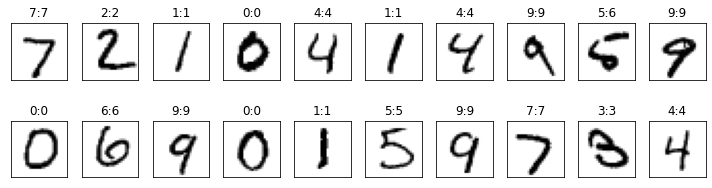

In [19]:
image_test = x_test * 255.0

# 이미지 출력
plt.figure(figsize=(10, 3))

for i in range(20): 
    # i번째 ax 객체에 접근
    ax = plt.subplot(2, 10, i+1)
    
    # i번째 이미지 데이터에 접근
    img = image_test[i].reshape(28,28)
    
    # 이미지를 출력
    ax.imshow(img, cmap='gray_r')
    
    # (정답데이터):(예측결과)를 타이틀로
    title = f'{y_test.values[i]}:{y_pred[i]}'
    ax.set_title(title)
    
    # x, y눈금 숨김
    ax.set_xticks([])
    ax.set_yticks([])

# 인접 이미지와 간격 설정
plt.tight_layout()

# 화면 출력
plt.show()     

### A2.9 튜닝

#### 튜닝
케라스를 이용한 딥러닝 모델과 정확도를 비교한다

In [20]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12
pixel_size = 28

In [21]:
# 딥러닝에 사용할 수 있도록 입력 데이터를 변형

# 학습 데이터
x_train_tf = x_train.reshape(x_train.shape[0], 
    pixel_size, pixel_size, 1)

# 검증 데이터
x_test_tf = x_test.reshape(x_test.shape[0], 
    pixel_size, pixel_size, 1)

# 입력 데이터 형식
input_shape = x_train_tf.shape[1:]

# 결과 확인
print(input_shape)

(28, 28, 1)


In [22]:
# 딥러닝 모델 생성
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [23]:
# 손실함수, 정확도, 학습 알고리즘 지정

# 손실함수
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# 정확도
acc = tf.keras.metrics.SparseCategoricalAccuracy()

# 학습 알고리즘
optim = tf.keras.optimizers.Adam()

# 모델과 결합
model.compile(optimizer=optim, loss=loss, metrics=[acc])

#### 학습
소요시간  
약 30분(GPU 미사용)  
약 1분(GPU 사용시)


In [24]:
# 학습
model.fit(x_train_tf, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_tf, y_test))

Epoch 1/12
469/469 [==============================] - 7s 9ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9264 - val_loss: 0.0583 - val_sparse_categorical_accuracy: 0.9803
Epoch 2/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0825 - sparse_categorical_accuracy: 0.9758 - val_loss: 0.0374 - val_sparse_categorical_accuracy: 0.9880
Epoch 3/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0308 - val_sparse_categorical_accuracy: 0.9894
Epoch 4/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9894
Epoch 5/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9893
Epoch 6/12
469/469 [==============================] - 4s 9ms/step - loss: 0.0374 - sparse_categorica

#### 예측 및 평가

In [25]:
# 예측 결과 받아오기
y_pred_tf = np.argmax(model.predict(x_test_tf), axis=-1)

In [26]:
# 혼동행렬 출력
cm2 = confusion_matrix(y_test, y_pred_tf, labels=labels)
cm2_labeled = make_cm(cm2, labels_str)
display(cm2_labeled)

예측결과                                                 
           0     1     2     3    4    5    6     7    8    9
정답데이터 0  976     0     1     0    1    0    1     1    0    0
      1    0  1134     0     1    0    0    0     0    0    0
      2    1     2  1022     2    0    0    0     5    0    0
      3    0     0     0  1008    0    1    0     1    0    0
      4    0     1     0     0  975    0    4     0    0    2
      5    0     0     0     9    0  880    2     1    0    0
      6    3     4     0     2    1    3  944     0    1    0
      7    0     2     3     0    0    0    0  1022    1    0
      8    3     1     3     2    3    0    0     2  957    3
      9    1     1     0     3    7    2    0     6    2  987

In [27]:
# 정밀도, 재현율, F-점수 출력
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_tf, digits=4))

              precision    recall  f1-score   support

           0     0.9919    0.9959    0.9939       980
           1     0.9904    0.9991    0.9947      1135
           2     0.9932    0.9903    0.9918      1032
           3     0.9815    0.9980    0.9897      1010
           4     0.9878    0.9929    0.9904       982
           5     0.9932    0.9865    0.9899       892
           6     0.9926    0.9854    0.9890       958
           7     0.9846    0.9942    0.9894      1028
           8     0.9958    0.9825    0.9891       974
           9     0.9950    0.9782    0.9865      1009

    accuracy                         0.9905     10000
   macro avg     0.9906    0.9903    0.9904     10000
weighted avg     0.9905    0.9905    0.9905     10000



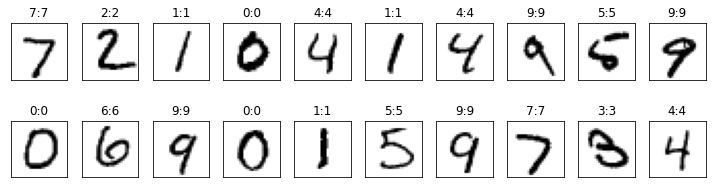

In [28]:
# 이미지 출력
plt.figure(figsize=(10, 3))

for i in range(20): 
    # i번째 ax 객체 접근
    ax = plt.subplot(2, 10, i+1)
    
    # i번째 이미지 데이터 접근
    img = image_test[i].reshape(28,28)
    
    # 이미지 출력
    ax.imshow(img, cmap='gray_r')
    
    # (정답 데이터):(예측결과) 형식으로 타이틀 추가
    title = f'{y_test.values[i]}:{y_pred_tf[i]}'
    ax.set_title(title)
    
    # x, y눈금 숨김
    ax.set_xticks([])
    ax.set_yticks([])

# 인접 이미지와 간격 설정
plt.tight_layout()

# 화면 출력
plt.show()         